In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler 
from sklearn.preprocessing import RobustScaler, Normalizer, QuantileTransformer, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from sklearn import preprocessing

In [2]:
#Loading in the dataset
magic_df = pd.read_csv("magic04.data", header = None)
magic_df.columns = ["fLength", "fWidth", "fSize", "fConc","fConc1","fAsym","fM3Long","fM3Trans","fAlpha","fDist","class"]
magic_df

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g
...,...,...,...,...,...,...,...,...,...,...,...
19015,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,h
19016,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,h
19017,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,h
19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,h


In [3]:
#Standardizing data
magic_df["class"] = magic_df["class"].replace("g", "1")
magic_df["class"] = magic_df["class"].replace("h", "2")

def standardize(string):
    output = int(string)
    return output

magic_df["class"] = magic_df["class"].apply(standardize)

## Logistic Regression

#### Trial 1

In [4]:
#Defining X and Y
X_magic = magic_df.iloc[:,0:10]
Y_magic = magic_df.loc[:, "class"]
X_train, X_test, Y_train, Y_test = train_test_split( X_magic, Y_magic, train_size=5000, shuffle=True, random_state = 1)

In [5]:
%%time
# Create a pipeline - RF is a stand in, we will populate the classifier part below
pipe = Pipeline([('std', StandardScaler()),
                 ('classifier', LogisticRegression())])

# Create search space of candidate learning algorithms and their hyperparameters
# note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}
                ]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5),
                   scoring=['accuracy', 'precision','f1_micro'], refit=False,
                   verbose=0)

# Fit grid search
best_model = clf.fit(X_train, Y_train)

Wall time: 3.97 s


In [6]:
best_model.cv_results_

{'mean_fit_time': array([0.00877638, 0.01336441, 0.01782269, 0.01416168, 0.01406498,
        0.01396246, 0.0332684 , 0.0241756 , 0.03071957, 0.0254034 ,
        0.03698459, 0.02273903, 0.03769841, 0.02453885, 0.03490677,
        0.03071718, 0.04597917, 0.03291483, 0.01067314, 0.00857687,
        0.00957465, 0.0119678 , 0.02234077, 0.01775246, 0.02612944,
        0.01715441, 0.01755333, 0.01555853, 0.02732692]),
 'std_fit_time': array([0.00324088, 0.00079848, 0.00628271, 0.00159635, 0.00090864,
        0.0010928 , 0.01225252, 0.00225381, 0.0111    , 0.00604559,
        0.00395461, 0.00510089, 0.00525485, 0.00681697, 0.00862552,
        0.00305105, 0.01770194, 0.00225301, 0.00298404, 0.00048852,
        0.00048842, 0.00154474, 0.00371059, 0.00203385, 0.01095035,
        0.00270634, 0.0032532 , 0.00184995, 0.00552056]),
 'mean_score_time': array([0.00478721, 0.00438833, 0.0057848 , 0.00438876, 0.00379038,
        0.00398941, 0.00398445, 0.00409074, 0.0033896 , 0.00317659,
        0.003796

In [7]:
best_model.cv_results_['rank_test_accuracy']

array([28, 26, 28, 24, 23, 21,  2, 17,  1, 19,  2,  2,  2,  2,  2,  2,  2,
        2, 26, 24, 21, 17, 19,  2,  2,  2,  2,  2,  2])

In [8]:
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [9]:
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_precision'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 10.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [10]:
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3390
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3332
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3390
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2378
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2084
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2042
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.2014
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.2016
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.2012
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.2016


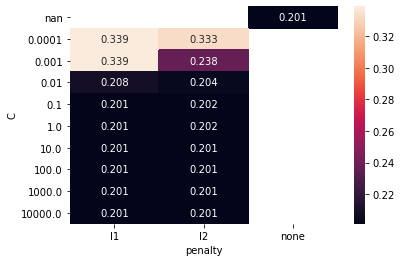

In [11]:
results = pd.DataFrame( best_model.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results['score_acc'] = 1 - best_model.cv_results_['mean_test_accuracy']

# get rid of classifierXX in columns
cols = results.columns.to_series().str.split('__').apply(lambda x: x[-1])
results.columns = cols

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results

In [218]:
#assigning result
acc_1 = ("c = 1.0, penalty = l1, solver = saga, acc = 0.2012")

,classifier,C,penalty,solver,score_precision
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.339000
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.335141
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.339000
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.256704
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.205039
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.199569
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.190435
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.189987
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.188712
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.188980


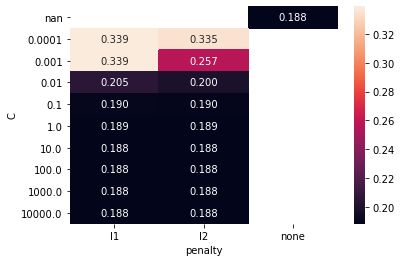

In [13]:
results = pd.DataFrame( best_model.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results['score_precision'] = 1 - best_model.cv_results_['mean_test_precision']

# get rid of classifierXX in columns
cols = results.columns.to_series().str.split('__').apply(lambda x: x[-1])
results.columns = cols

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results.query('solver=="saga"').pivot('C','penalty','score_precision'),
             annot=True, fmt='.3f')

results

In [219]:
#assigning result
precision_1 = ("C = 10, penality = l1, solver = saga, precision = 0.188416")

,classifier,C,penalty,solver,score_f1_micro
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3390
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3332
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3390
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2378
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2084
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2042
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.2014
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.2016
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.2012
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.2016


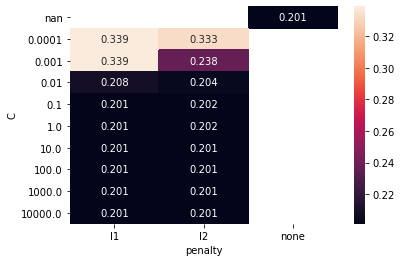

In [15]:
results = pd.DataFrame( best_model.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results['score_f1_micro'] = 1 - best_model.cv_results_['mean_test_f1_micro']

# get rid of classifierXX in columns
cols = results.columns.to_series().str.split('__').apply(lambda x: x[-1])
results.columns = cols

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results.query('solver=="saga"').pivot('C','penalty','score_f1_micro'),
             annot=True, fmt='.3f')

results

In [220]:
#assigning result
f1micro_1 = ("c = 1.0, penalty = l1, solver = saga, f1_micro = 0.2012")

#### Trial 2

In [17]:
#Defining X and Y
X_magic = magic_df.iloc[:,0:10]
Y_magic = magic_df.loc[:, "class"]
X_train, X_test, Y_train, Y_test = train_test_split( X_magic, Y_magic, train_size=5000, shuffle=True, random_state = 2)

In [18]:
%%time
# Create a pipeline - RF is a stand in, we will populate the classifier part below
pipe = Pipeline([('std', StandardScaler()),
                 ('classifier', LogisticRegression())])

# Create search space of candidate learning algorithms and their hyperparameters
# note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}
                ]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5),
                   scoring=['accuracy', 'precision','f1_micro'], refit=False,
                   verbose=0)

# Fit grid search
best_model2 = clf.fit(X_train, Y_train)

Wall time: 3.78 s


In [19]:
best_model2.cv_results_

{'mean_fit_time': array([0.0065773 , 0.01535873, 0.00817776, 0.01356645, 0.01456065,
        0.01176553, 0.01375666, 0.02284007, 0.03198733, 0.03130651,
        0.03889742, 0.03251443, 0.03959084, 0.03151956, 0.04041271,
        0.0329113 , 0.04308414, 0.03351021, 0.00797839, 0.00837765,
        0.0111702 , 0.01186976, 0.01695371, 0.01555681, 0.01446333,
        0.01336417, 0.01216745, 0.01585903, 0.03321643]),
 'std_fit_time': array([4.94070108e-04, 2.86306951e-03, 7.46162062e-04, 1.18547376e-03,
        1.01737357e-03, 1.16741604e-03, 7.39382729e-04, 1.59998955e-03,
        7.49061606e-03, 2.14914504e-03, 2.67527073e-03, 1.02064113e-03,
        2.42708997e-03, 1.35466894e-03, 2.50362111e-03, 1.09257998e-03,
        4.43346289e-03, 2.05328474e-03, 9.53674316e-08, 7.97820111e-04,
        1.16302295e-03, 1.11015314e-03, 1.78323433e-03, 7.98646270e-04,
        1.99768661e-03, 1.01745762e-03, 3.98755341e-04, 2.89598020e-03,
        2.88633496e-03]),
 'mean_score_time': array([0.00518656, 

In [20]:
best_model2.cv_results_['rank_test_accuracy']

array([28, 26, 28, 24, 23, 21, 18, 18, 17, 15,  1,  1,  1,  1,  1,  1,  1,
        1, 26, 24, 21, 18, 15,  1,  1,  1,  1,  1,  1])

In [21]:
best_model2.cv_results_['params'][ np.argmin(best_model2.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 10.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [22]:
best_model2.cv_results_['params'][ np.argmin(best_model2.cv_results_['rank_test_precision'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 10.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [23]:
best_model2.cv_results_['params'][ np.argmin(best_model2.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 10.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3540
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3472
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3540
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2534
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2178
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2156
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.2120
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.2120
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.2114
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.2112


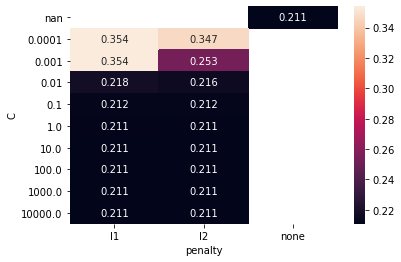

In [24]:
results2 = pd.DataFrame( best_model2.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results2['score_acc'] = 1 - best_model2.cv_results_['mean_test_accuracy']

# get rid of classifierXX in columns
cols2 = results2.columns.to_series().str.split('__').apply(lambda x: x[-1])
results2.columns = cols2

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results2.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results2

In [221]:
#assigning result
acc_2 = ("c = 10.0, penalty = l1, solver = saga, acc = 0.2108")

,classifier,C,penalty,solver,score_precision
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.354000
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.349575
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.354000
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.268758
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.216280
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.210595
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.200762
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.200485
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.199290
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.199055


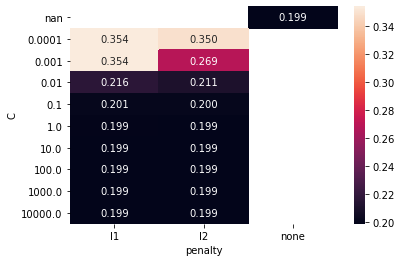

In [26]:
results2 = pd.DataFrame( best_model2.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results2['score_precision'] = 1 - best_model2.cv_results_['mean_test_precision']

# get rid of classifierXX in columns
cols2 = results2.columns.to_series().str.split('__').apply(lambda x: x[-1])
results2.columns = cols2

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results2.query('solver=="saga"').pivot('C','penalty','score_precision'),
             annot=True, fmt='.3f')

results2

In [222]:
#assigning result
precision_2 = ("c = 10.0, penalty = l1, solver = saga, precision = 0.198584")

,classifier,C,penalty,solver,score_f1_micro
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3540
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3472
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3540
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2534
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2178
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2156
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.2120
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.2120
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.2114
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.2112


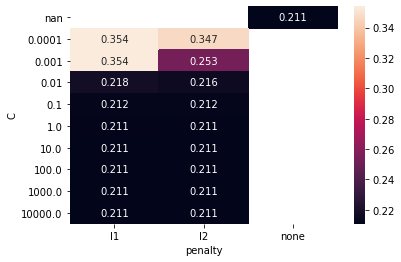

In [28]:
results2 = pd.DataFrame( best_model2.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results2['score_f1_micro'] = 1 - best_model2.cv_results_['mean_test_f1_micro']

# get rid of classifierXX in columns
cols2 = results2.columns.to_series().str.split('__').apply(lambda x: x[-1])
results2.columns = cols2

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results2.query('solver=="saga"').pivot('C','penalty','score_f1_micro'),
             annot=True, fmt='.3f')

results2

In [223]:
#assigning result
f1micro_2 = ("c = 10.0, penalty = l1, solver = saga, f1_micro = 0.2108")

#### Trial 3

In [30]:
#Defining X and Y
X_magic = magic_df.iloc[:,0:10]
Y_magic = magic_df.loc[:, "class"]
X_train, X_test, Y_train, Y_test = train_test_split( X_magic, Y_magic, train_size=5000, shuffle=True, random_state = 3)

In [31]:
%%time
# Create a pipeline - RF is a stand in, we will populate the classifier part below
pipe = Pipeline([('std', StandardScaler()),
                 ('classifier', LogisticRegression())])

# Create search space of candidate learning algorithms and their hyperparameters
# note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}
                ]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5),
                   scoring=['accuracy', 'precision', 'f1_micro'], refit=False,
                   verbose=0)

# Fit grid search
best_model3 = clf.fit(X_train, Y_train)

Wall time: 3.8 s


In [32]:
best_model3.cv_results_

{'mean_fit_time': array([0.00589128, 0.01236653, 0.00937524, 0.0129714 , 0.01515326,
        0.01396246, 0.0209455 , 0.02293539, 0.03292341, 0.03031921,
        0.03968196, 0.03005838, 0.03771353, 0.03230233, 0.04208841,
        0.02932167, 0.03756356, 0.03261914, 0.00957451, 0.01136999,
        0.01176858, 0.01156907, 0.01495996, 0.01615682, 0.02693214,
        0.01278806, 0.012989  , 0.01249113, 0.03088665]),
 'std_fit_time': array([0.00110996, 0.0010167 , 0.00079744, 0.00109277, 0.00096716,
        0.00063128, 0.00916134, 0.0020876 , 0.00427388, 0.00286072,
        0.00255353, 0.00391525, 0.00452351, 0.0041245 , 0.00414445,
        0.00541137, 0.006901  , 0.00364067, 0.00119665, 0.00486982,
        0.00311575, 0.00048904, 0.00154533, 0.00291856, 0.01769397,
        0.00075824, 0.00090124, 0.00113872, 0.00385044]),
 'mean_score_time': array([0.00398378, 0.0033915 , 0.00378981, 0.00318937, 0.00338588,
        0.00359044, 0.00339246, 0.00339537, 0.00337982, 0.00340328,
        0.003195

In [33]:
best_model3.cv_results_['rank_test_accuracy']

array([28, 26, 28, 24, 23, 21, 20, 18, 17,  1,  3,  3,  3,  3,  3,  3,  3,
        3, 26, 24, 21, 18,  1,  3,  3,  3,  3,  3,  3])

In [34]:
best_model3.cv_results_['params'][ np.argmin(best_model3.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

In [35]:
best_model3.cv_results_['params'][ np.argmin(best_model3.cv_results_['rank_test_precision'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

In [36]:
best_model3.cv_results_['params'][ np.argmin(best_model3.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3562
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3480
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3562
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2504
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2194
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2154
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.2110
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.2100
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.2094
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.2090


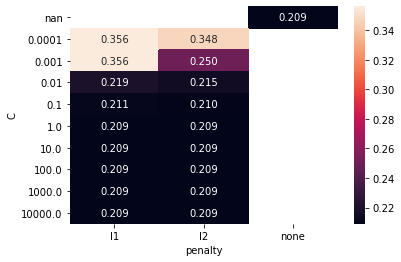

In [37]:
results3 = pd.DataFrame( best_model3.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results3['score_acc'] = 1 - best_model3.cv_results_['mean_test_accuracy']

# get rid of classifierXX in columns
cols3 = results3.columns.to_series().str.split('__').apply(lambda x: x[-1])
results3.columns = cols3

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results3.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results3

In [224]:
#assigning result
acc_3 = ("c = 1.0, penalty = l2, solver = saga, acc = 0.2090")

,classifier,C,penalty,solver,score_precision
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.356200
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.350873
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.356200
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.267178
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.216501
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.211941
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.201437
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.200708
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.199714
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.199272


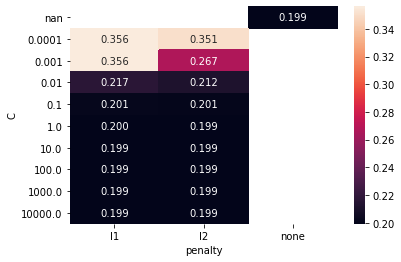

In [39]:
results3 = pd.DataFrame( best_model3.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results3['score_precision'] = 1 - best_model3.cv_results_['mean_test_precision']

# get rid of classifierXX in columns
cols3 = results3.columns.to_series().str.split('__').apply(lambda x: x[-1])
results3.columns = cols3

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results3.query('solver=="saga"').pivot('C','penalty','score_precision'),
             annot=True, fmt='.3f')

results3

In [225]:
#assigning result
precision_3 = ("C = 1.0, penality = l2, solver = saga, precision = 0.199272")

,classifier,C,penalty,solver,score_f1_micro
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3562
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3480
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3562
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2504
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2194
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2154
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.2110
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.2100
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.2094
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.2090


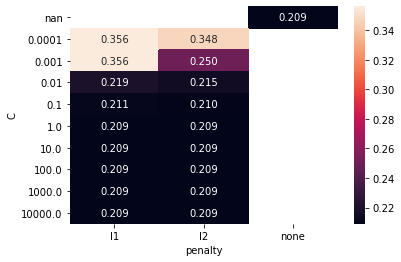

In [41]:
results3 = pd.DataFrame( best_model3.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results3['score_f1_micro'] = 1 - best_model3.cv_results_['mean_test_f1_micro']

# get rid of classifierXX in columns
cols3 = results3.columns.to_series().str.split('__').apply(lambda x: x[-1])
results3.columns = cols3

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results3.query('solver=="saga"').pivot('C','penalty','score_f1_micro'),
             annot=True, fmt='.3f')

results3

In [226]:
#assigning result
f1micro_3 = ("c = 1.0, penalty = l2, solver = saga, f1_micro = 0.2090")

#### Trial 4

In [43]:
#Defining X and Y
X_magic = magic_df.iloc[:,0:10]
Y_magic = magic_df.loc[:, "class"]
X_train, X_test, Y_train, Y_test = train_test_split( X_magic, Y_magic, train_size=5000, shuffle=True, random_state = 4)

In [44]:
%%time
# Create a pipeline - RF is a stand in, we will populate the classifier part below
pipe = Pipeline([('std', StandardScaler()),
                 ('classifier', LogisticRegression())])

# Create search space of candidate learning algorithms and their hyperparameters
# note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}
                ]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5),
                   scoring=['accuracy', 'precision', 'f1_micro'], refit=False,
                   verbose=0)

# Fit grid search
best_model4 = clf.fit(X_train, Y_train)

Wall time: 3.67 s


In [45]:
best_model4.cv_results_

{'mean_fit_time': array([0.0091754 , 0.01296525, 0.00898514, 0.01515374, 0.01366391,
        0.01269202, 0.01416783, 0.02053881, 0.02988648, 0.02723193,
        0.03729739, 0.02932148, 0.03789887, 0.02992001, 0.03789105,
        0.03102202, 0.03410869, 0.02853584, 0.00837731, 0.00857701,
        0.0103723 , 0.0123672 , 0.01276565, 0.01456137, 0.0147603 ,
        0.01994667, 0.01835108, 0.01765423, 0.03331933]),
 'std_fit_time': array([0.00353469, 0.00089207, 0.00063755, 0.0017164 , 0.00124546,
        0.00115667, 0.0009877 , 0.00049589, 0.00804826, 0.00214669,
        0.00427629, 0.0016204 , 0.00302513, 0.00295839, 0.00178527,
        0.00346402, 0.00363697, 0.00407357, 0.00048852, 0.00101746,
        0.00079756, 0.00079813, 0.00074642, 0.00119704, 0.00116316,
        0.00738301, 0.00453101, 0.00336198, 0.00182493]),
 'mean_score_time': array([0.0057847 , 0.00319161, 0.00338726, 0.00538607, 0.00319171,
        0.00340338, 0.00316586, 0.00359621, 0.00359912, 0.00359602,
        0.003196

In [46]:
best_model4.cv_results_['rank_test_accuracy']

array([28, 26, 28, 24, 23,  2, 21,  3, 22,  5,  7,  7,  7,  7,  7,  7,  7,
        7, 26, 24,  1,  3,  5,  7,  7,  7,  7,  7,  7])

In [47]:
best_model4.cv_results_['params'][ np.argmin(best_model4.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.01,
 'classifier__penalty': 'l2',
 'classifier__solver': 'lbfgs'}

In [48]:
best_model4.cv_results_['params'][ np.argmin(best_model4.cv_results_['rank_test_precision'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

In [49]:
best_model4.cv_results_['params'][ np.argmin(best_model4.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.01,
 'classifier__penalty': 'l2',
 'classifier__solver': 'lbfgs'}

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3588
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3476
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3588
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2512
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2198
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2160
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.2172
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.2162
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.2174
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.2170


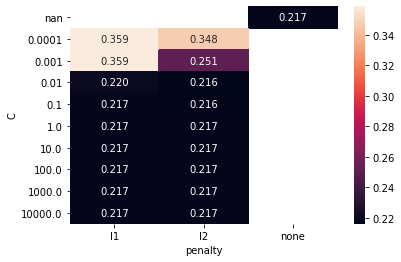

In [50]:
results4 = pd.DataFrame( best_model4.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results4['score_acc'] = 1 - best_model4.cv_results_['mean_test_accuracy']

# get rid of classifierXX in columns
cols4 = results4.columns.to_series().str.split('__').apply(lambda x: x[-1])
results4.columns = cols4

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results4.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results4

In [227]:
#assigning result
acc_4 = ("c = 0.01, penalty = l2, solver = lbfgs, acc = 0.2158")

,classifier,C,penalty,solver,score_precision
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.358800
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.351523
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.358800
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.268079
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.217154
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.211983
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.204997
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.204234
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.204558
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.204111


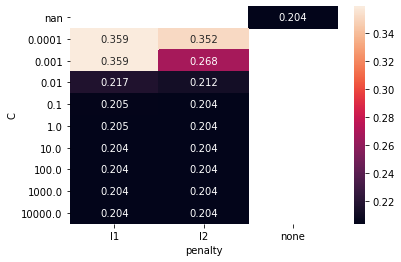

In [52]:
results4 = pd.DataFrame( best_model4.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results4['score_precision'] = 1 - best_model4.cv_results_['mean_test_precision']

# get rid of classifierXX in columns
cols4 = results4.columns.to_series().str.split('__').apply(lambda x: x[-1])
results4.columns = cols4

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results4.query('solver=="saga"').pivot('C','penalty','score_precision'),
             annot=True, fmt='.3f')

results4

In [228]:
#assigning result
precision_4 = ("c = 1.0, penalty = l2, solver = saga, precision = 0.204111")

,classifier,C,penalty,solver,score_f1_micro
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3588
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3476
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3588
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2512
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2198
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2160
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.2172
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.2162
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.2174
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.2170


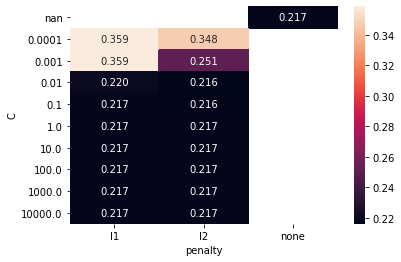

In [54]:
results4 = pd.DataFrame( best_model4.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results4['score_f1_micro'] = 1 - best_model4.cv_results_['mean_test_f1_micro']

# get rid of classifierXX in columns
cols4 = results4.columns.to_series().str.split('__').apply(lambda x: x[-1])
results4.columns = cols4

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results4.query('solver=="saga"').pivot('C','penalty','score_f1_micro'),
             annot=True, fmt='.3f')

results4

In [229]:
#assigning result
f1micro_4 = ("c = 0.01, penalty = l2, solver = lbfgs, f1_micro = 0.2158")

#### Trial 5

In [56]:
#Defining X and Y
X_magic = magic_df.iloc[:,0:10]
Y_magic = magic_df.loc[:, "class"]
X_train, X_test, Y_train, Y_test = train_test_split( X_magic, Y_magic, train_size=5000, shuffle=True, random_state = 5)

In [57]:
%%time
# Create a pipeline - RF is a stand in, we will populate the classifier part below
pipe = Pipeline([('std', StandardScaler()),
                 ('classifier', LogisticRegression())])

# Create search space of candidate learning algorithms and their hyperparameters
# note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}
                ]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5),
                   scoring=['accuracy', 'precision', 'f1_micro'], refit=False,
                   verbose=0)

# Fit grid search
best_model5 = clf.fit(X_train, Y_train)

Wall time: 5.29 s


In [58]:
best_model5.cv_results_

{'mean_fit_time': array([0.02872291, 0.01855016, 0.01535926, 0.01989236, 0.01575756,
        0.0155582 , 0.02672849, 0.02234039, 0.04228692, 0.03131614,
        0.06339083, 0.04019446, 0.04308515, 0.06035485, 0.05436072,
        0.03071785, 0.04328394, 0.03729992, 0.02892303, 0.00937428,
        0.01376324, 0.03051829, 0.02134275, 0.01815133, 0.01775246,
        0.02672868, 0.05724678, 0.01934834, 0.03730001]),
 'std_fit_time': array([0.02887368, 0.00162059, 0.00286298, 0.00513632, 0.00146585,
        0.00135295, 0.01137849, 0.00376381, 0.0101436 , 0.00606975,
        0.02375004, 0.00823727, 0.00132298, 0.02193589, 0.01850884,
        0.00369943, 0.01014372, 0.00457452, 0.0295722 , 0.00101744,
        0.00230907, 0.01304344, 0.00360141, 0.00247518, 0.0027056 ,
        0.00980019, 0.04109012, 0.00241003, 0.00348919]),
 'mean_score_time': array([0.00518627, 0.00498695, 0.00558496, 0.00638313, 0.00398941,
        0.00478725, 0.00389161, 0.00478725, 0.00498667, 0.00418916,
        0.004189

In [59]:
best_model5.cv_results_['rank_test_accuracy']

array([28, 26, 28, 24, 23, 21,  1, 19, 18, 16, 15,  2,  2,  2,  2,  2,  2,
        2, 26, 24, 21, 19, 16,  2,  2,  2,  2,  2,  2])

In [60]:
best_model5.cv_results_['params'][ np.argmin(best_model5.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [61]:
best_model5.cv_results_['params'][ np.argmin(best_model5.cv_results_['rank_test_precision'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 10.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

In [62]:
best_model5.cv_results_['params'][ np.argmin(best_model5.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3474
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3398
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3474
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2494
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2172
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2164
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.2076
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.2102
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.2096
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.2094


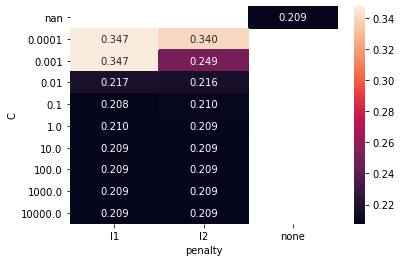

In [63]:
results5 = pd.DataFrame( best_model5.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results5['score_acc'] = 1 - best_model5.cv_results_['mean_test_accuracy']

# get rid of classifierXX in columns
cols5 = results5.columns.to_series().str.split('__').apply(lambda x: x[-1])
results5.columns = cols5

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results5.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results5

In [230]:
#assigning result
acc_5 = ("c = 0.1, penalty = l1, solver = saga, acc = 0.2076")

,classifier,C,penalty,solver,score_precision
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.347400
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.342395
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.347400
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.266850
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.214513
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.209879
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.196961
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.198479
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.196847
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.196950


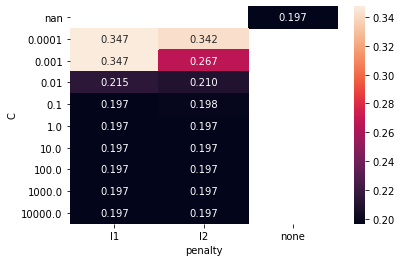

In [65]:
results5 = pd.DataFrame( best_model5.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results5['score_precision'] = 1 - best_model5.cv_results_['mean_test_precision']

# get rid of classifierXX in columns
cols5 = results5.columns.to_series().str.split('__').apply(lambda x: x[-1])
results5.columns = cols5

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results5.query('solver=="saga"').pivot('C','penalty','score_precision'),
             annot=True, fmt='.3f')

results5

In [231]:
#assigning result
precision_5 = ("C = 10.0, penality = l2, solver = saga, precision = 0.196507")

,classifier,C,penalty,solver,score_f1_micro
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3474
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3398
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3474
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2494
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2172
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2164
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.2076
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.2102
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.2096
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.2094


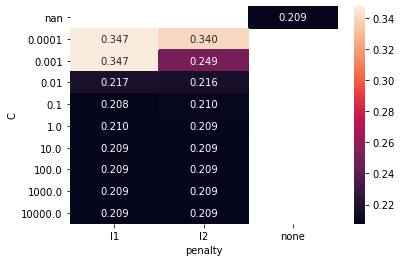

In [67]:
results5 = pd.DataFrame( best_model5.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results5['score_f1_micro'] = 1 - best_model5.cv_results_['mean_test_f1_micro']

# get rid of classifierXX in columns
cols5 = results5.columns.to_series().str.split('__').apply(lambda x: x[-1])
results5.columns = cols5

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results5.query('solver=="saga"').pivot('C','penalty','score_f1_micro'),
             annot=True, fmt='.3f')

results5

In [232]:
#assigning result
f1micro_5 = ("c = 0.1, penalty = l1, solver = saga, f1_micro = 0.2076")

#### Trial 6

In [69]:
#Defining X and Y
X_magic = magic_df.iloc[:,0:10]
Y_magic = magic_df.loc[:, "class"]
X_train, X_test, Y_train, Y_test = train_test_split( X_magic, Y_magic, train_size=5000, shuffle=True, random_state = 6)

In [70]:
%%time
# Create a pipeline - RF is a stand in, we will populate the classifier part below
pipe = Pipeline([('std', StandardScaler()),
                 ('classifier', LogisticRegression())])

# Create search space of candidate learning algorithms and their hyperparameters
# note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}
                ]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5),
                   scoring=['accuracy', 'precision', 'f1_micro'], refit=False,
                   verbose=0)

# Fit grid search
best_model6 = clf.fit(X_train, Y_train)

Wall time: 6.15 s


In [71]:
best_model6.cv_results_

{'mean_fit_time': array([0.00718117, 0.01645784, 0.00987496, 0.01216764, 0.01905003,
        0.01436105, 0.01715331, 0.02752609, 0.04607673, 0.04607677,
        0.05465398, 0.04399247, 0.05161824, 0.03799949, 0.04717979,
        0.03680296, 0.0452786 , 0.04707403, 0.05615168, 0.07021279,
        0.03470674, 0.02652884, 0.03430815, 0.05385566, 0.1124989 ,
        0.01775212, 0.02274055, 0.02114334, 0.04392872]),
 'std_fit_time': array([0.00074616, 0.00178677, 0.00091757, 0.00074668, 0.00127739,
        0.00135303, 0.00116335, 0.00439694, 0.0100804 , 0.00336171,
        0.00612845, 0.00380154, 0.00701187, 0.00822741, 0.00670401,
        0.00351616, 0.01197804, 0.01992092, 0.03952589, 0.0593884 ,
        0.0079135 , 0.01566301, 0.03046427, 0.01712406, 0.12448928,
        0.00364524, 0.00603189, 0.00486155, 0.00787011]),
 'mean_score_time': array([0.00359044, 0.00418835, 0.00319176, 0.00359044, 0.00399032,
        0.00398998, 0.00379043, 0.00339122, 0.00398932, 0.00618339,
        0.004388

In [72]:
best_model6.cv_results_['rank_test_accuracy']

array([28, 26, 28, 24, 21, 22,  1, 19,  2, 17,  3,  3,  3,  3,  3,  3,  3,
        3, 26, 24, 22, 19, 17,  3,  3,  3,  3,  3,  3])

In [73]:
best_model6.cv_results_['params'][ np.argmin(best_model6.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [74]:
best_model6.cv_results_['params'][ np.argmin(best_model6.cv_results_['rank_test_precision'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [75]:
best_model6.cv_results_['params'][ np.argmin(best_model6.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3464
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3398
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3464
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2498
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2136
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2144
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.2084
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.2098
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.2088
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.2094


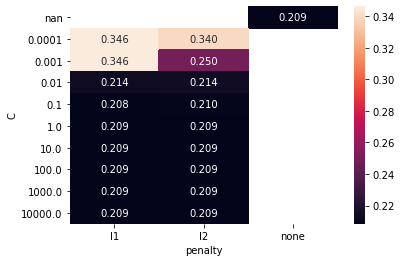

In [76]:
results6 = pd.DataFrame( best_model6.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results6['score_acc'] = 1 - best_model6.cv_results_['mean_test_accuracy']

# get rid of classifierXX in columns
cols6 = results6.columns.to_series().str.split('__').apply(lambda x: x[-1])
results6.columns = cols6

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results6.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results6

In [233]:
#assigning result
acc_6 = ("c = 0.1, penalty = l1, solver = saga, acc = 0.2084")

,classifier,C,penalty,solver,score_precision
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.346400
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.342048
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.346400
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.264702
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.208475
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.207605
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.196021
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.196542
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.195254
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.195580


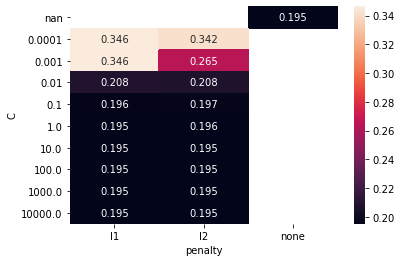

In [78]:
results6 = pd.DataFrame( best_model6.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results6['score_precision'] = 1 - best_model6.cv_results_['mean_test_precision']

# get rid of classifierXX in columns
cols6 = results6.columns.to_series().str.split('__').apply(lambda x: x[-1])
results6.columns = cols6

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results6.query('solver=="saga"').pivot('C','penalty','score_precision'),
             annot=True, fmt='.3f')

results6

In [234]:
#assigning result
precision_6 = ("C = 1.0, penality = l1, solver = saga, precision = 0.195254")

,classifier,C,penalty,solver,score_f1_micro
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3464
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3398
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3464
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2498
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2136
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2144
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.2084
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.2098
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.2088
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.2094


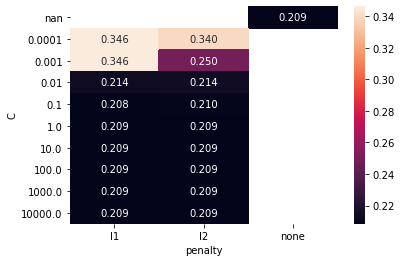

In [80]:
results6 = pd.DataFrame( best_model6.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results6['score_f1_micro'] = 1 - best_model6.cv_results_['mean_test_f1_micro']

# get rid of classifierXX in columns
cols6 = results6.columns.to_series().str.split('__').apply(lambda x: x[-1])
results6.columns = cols6

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results6.query('solver=="saga"').pivot('C','penalty','score_f1_micro'),
             annot=True, fmt='.3f')

results6

In [235]:
#assigning result
f1micro_6 = ("c = 0.1, penalty = l1, solver = saga, f1_micro = 0.2084")

#### Trial 7

In [82]:
#Defining X and Y
X_magic = magic_df.iloc[:,0:10]
Y_magic = magic_df.loc[:, "class"]
X_train, X_test, Y_train, Y_test = train_test_split( X_magic, Y_magic, train_size=5000, shuffle=True, random_state = 7)

In [83]:
%%time
# Create a pipeline - RF is a stand in, we will populate the classifier part below
pipe = Pipeline([('std', StandardScaler()),
                 ('classifier', LogisticRegression())])

# Create search space of candidate learning algorithms and their hyperparameters
# note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}
                ]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5),
                   scoring=['accuracy', 'precision','f1_micro'], refit=False,
                   verbose=0)

# Fit grid search
best_model7 = clf.fit(X_train, Y_train)

Wall time: 5.31 s


In [84]:
best_model7.cv_results_

{'mean_fit_time': array([0.00738044, 0.01535873, 0.01316481, 0.02672811, 0.0267283 ,
        0.01994672, 0.03131609, 0.03893852, 0.04647422, 0.05057302,
        0.04059744, 0.03196125, 0.03749986, 0.04268813, 0.05624957,
        0.03291197, 0.03630228, 0.03530545, 0.03041987, 0.02044678,
        0.04059291, 0.02124496, 0.02523413, 0.02832241, 0.03460889,
        0.02623191, 0.01575775, 0.01725559, 0.03370967]),
 'std_fit_time': array([0.00184954, 0.00149288, 0.00305116, 0.00632027, 0.00529254,
        0.00652481, 0.00799404, 0.01604433, 0.00635353, 0.01353117,
        0.00611739, 0.00363892, 0.00162016, 0.00994463, 0.02241296,
        0.00109254, 0.00448686, 0.00763739, 0.01309013, 0.00444041,
        0.03807649, 0.00415267, 0.00567299, 0.00386753, 0.01270307,
        0.00395615, 0.00159618, 0.00097776, 0.0007462 ]),
 'mean_score_time': array([0.00478749, 0.00438848, 0.00598402, 0.00897603, 0.00538573,
        0.00478735, 0.0063828 , 0.00779386, 0.00738907, 0.00578933,
        0.004194

In [85]:
best_model7.cv_results_['rank_test_accuracy']

array([28, 26, 28, 24, 23, 21, 19,  1, 19,  1,  5,  5,  5,  5,  5,  5,  5,
        5, 26, 24, 21,  1,  1,  5,  5,  5,  5,  5,  5])

In [86]:
best_model7.cv_results_['params'][ np.argmin(best_model7.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.1,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

In [87]:
best_model7.cv_results_['params'][ np.argmin(best_model7.cv_results_['rank_test_precision'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

In [88]:
best_model7.cv_results_['params'][ np.argmin(best_model7.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.1,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3562
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3462
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3562
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2516
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2214
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2178
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.2152
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.2148
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.2152
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.2148


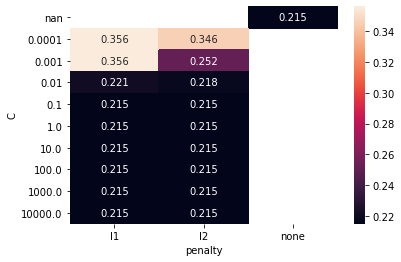

In [89]:
results7 = pd.DataFrame( best_model7.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results7['score_acc'] = 1 - best_model7.cv_results_['mean_test_accuracy']

# get rid of classifierXX in columns
cols7 = results7.columns.to_series().str.split('__').apply(lambda x: x[-1])
results7.columns = cols7

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results7.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results7

In [236]:
#assigning result
acc_7 = ("c = 0.1, penalty = l2, solver = saga, acc = 0.2148")

,classifier,C,penalty,solver,score_precision
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.356200
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.349692
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.356200
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.267532
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.219013
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.211918
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.204082
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.204188
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.202464
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.202359


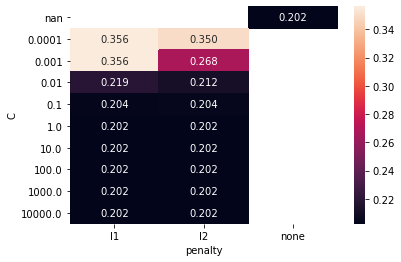

In [91]:
results7 = pd.DataFrame( best_model7.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results7['score_precision'] = 1 - best_model7.cv_results_['mean_test_precision']

# get rid of classifierXX in columns
cols7 = results7.columns.to_series().str.split('__').apply(lambda x: x[-1])
results7.columns = cols7

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results7.query('solver=="saga"').pivot('C','penalty','score_precision'),
             annot=True, fmt='.3f')

results7

In [237]:
#assigning result
precision_7 = ("C = 1.0, penality = l2, solver = saga, precision = 0.202359")

,classifier,C,penalty,solver,score_f1_micro
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3562
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3462
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3562
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2516
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2214
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2178
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.2152
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.2148
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.2152
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.2148


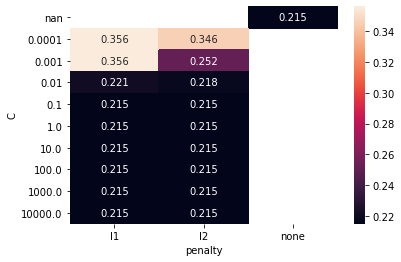

In [93]:
results7 = pd.DataFrame( best_model7.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results7['score_f1_micro'] = 1 - best_model7.cv_results_['mean_test_f1_micro']

# get rid of classifierXX in columns
cols7 = results7.columns.to_series().str.split('__').apply(lambda x: x[-1])
results7.columns = cols7

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results7.query('solver=="saga"').pivot('C','penalty','score_f1_micro'),
             annot=True, fmt='.3f')

results7

In [238]:
#assigning result
f1micro_7 = ("c = 0.1, penalty = l2, solver = saga, f1_micro = 0.2148")

#### Trial 8

In [95]:
#Defining X and Y
X_magic = magic_df.iloc[:,0:10]
Y_magic = magic_df.loc[:, "class"]
X_train, X_test, Y_train, Y_test = train_test_split( X_magic, Y_magic, train_size=5000, shuffle=True, random_state = 8)

In [96]:
%%time
# Create a pipeline - RF is a stand in, we will populate the classifier part below
pipe = Pipeline([('std', StandardScaler()),
                 ('classifier', LogisticRegression())])

# Create search space of candidate learning algorithms and their hyperparameters
# note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}
                ]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5),
                   scoring=['accuracy', 'precision','f1_micro'], refit=False,
                   verbose=0)

# Fit grid search
best_model8 = clf.fit(X_train, Y_train)

Wall time: 6.09 s


In [97]:
best_model8.cv_results_

{'mean_fit_time': array([0.01256647, 0.01865191, 0.00917583, 0.01376286, 0.01436129,
        0.01303868, 0.02303963, 0.02603197, 0.05156364, 0.04128919,
        0.04567804, 0.04248586, 0.04698901, 0.04368329, 0.04817247,
        0.04089403, 0.04717503, 0.03640385, 0.0149601 , 0.02393546,
        0.02134271, 0.03071799, 0.03271203, 0.03789897, 0.07227702,
        0.10198321, 0.05309577, 0.03518906, 0.05148139]),
 'std_fit_time': array([0.01033812, 0.00431907, 0.00039873, 0.00116289, 0.00048879,
        0.00127055, 0.00559044, 0.00219302, 0.01242989, 0.00587019,
        0.00247535, 0.01060401, 0.00287863, 0.00628856, 0.00193241,
        0.00472998, 0.00291936, 0.00312163, 0.00321645, 0.01371799,
        0.00312889, 0.00517857, 0.00813675, 0.01854087, 0.04062661,
        0.06807677, 0.02611013, 0.0172271 , 0.01443554]),
 'mean_score_time': array([0.00438776, 0.00398898, 0.00359044, 0.00330548, 0.00398946,
        0.00319128, 0.00808053, 0.00418882, 0.00538549, 0.00438857,
        0.004188

In [98]:
best_model8.cv_results_['rank_test_accuracy']

array([28, 26, 28, 24, 23, 21,  1, 19, 18, 16,  2,  2,  2,  2,  2,  2,  2,
        2, 26, 24, 21, 19, 16,  2,  2,  2,  2,  2,  2])

In [99]:
best_model8.cv_results_['params'][ np.argmin(best_model8.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [100]:
best_model8.cv_results_['params'][ np.argmin(best_model8.cv_results_['rank_test_precision'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 10.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [101]:
best_model8.cv_results_['params'][ np.argmin(best_model8.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3526
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3430
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3526
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2436
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2216
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2186
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.2132
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.2138
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.2138
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.2136


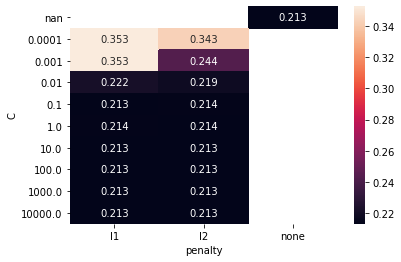

In [102]:
results8 = pd.DataFrame( best_model8.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results8['score_acc'] = 1 - best_model8.cv_results_['mean_test_accuracy']

# get rid of classifierXX in columns
cols8 = results8.columns.to_series().str.split('__').apply(lambda x: x[-1])
results8.columns = cols8

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results8.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results8

In [239]:
#assigning result
acc_8 = ("c = 0.1, penalty = l1, solver = saga, acc = 0.2132")

,classifier,C,penalty,solver,score_precision
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.352600
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.346253
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.352600
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.262793
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.217075
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.212867
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.202347
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.202797
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.202022
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.201798


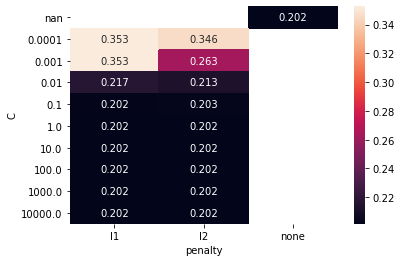

In [104]:
results8 = pd.DataFrame( best_model8.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results8['score_precision'] = 1 - best_model8.cv_results_['mean_test_precision']

# get rid of classifierXX in columns
cols8 = results8.columns.to_series().str.split('__').apply(lambda x: x[-1])
results8.columns = cols8

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results8.query('solver=="saga"').pivot('C','penalty','score_precision'),
             annot=True, fmt='.3f')

results8

In [240]:
#assigning result
precision_8 = ("c = 10.0, penalty = l1, solver = saga, precision = 0.201583")

,classifier,C,penalty,solver,score_f1_micro
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3526
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3430
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3526
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2436
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2216
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2186
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.2132
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.2138
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.2138
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.2136


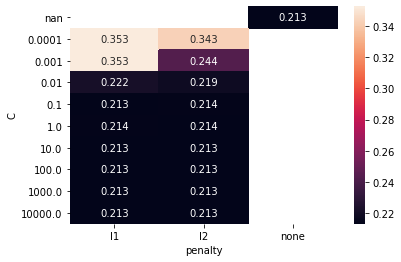

In [106]:
results8 = pd.DataFrame( best_model8.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results8['score_f1_micro'] = 1 - best_model8.cv_results_['mean_test_f1_micro']

# get rid of classifierXX in columns
cols8 = results8.columns.to_series().str.split('__').apply(lambda x: x[-1])
results8.columns = cols8

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results8.query('solver=="saga"').pivot('C','penalty','score_f1_micro'),
             annot=True, fmt='.3f')

results8

In [241]:
#assigning result
f1micro_8 = ("c = 0.1, penalty = l1, solver = saga, f1_micro = 0.2132")

#### Trial 9

In [108]:
#Defining X and Y
X_magic = magic_df.iloc[:,0:10]
Y_magic = magic_df.loc[:, "class"]
X_train, X_test, Y_train, Y_test = train_test_split( X_magic, Y_magic, train_size=5000, shuffle=True, random_state = 9)

In [109]:
%%time
# Create a pipeline - RF is a stand in, we will populate the classifier part below
pipe = Pipeline([('std', StandardScaler()),
                 ('classifier', LogisticRegression())])

# Create search space of candidate learning algorithms and their hyperparameters
# note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}
                ]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5),
                   scoring=['accuracy', 'precision','f1_micro'], refit=False,
                   verbose=0)

# Fit grid search
best_model9 = clf.fit(X_train, Y_train)

Wall time: 4.13 s


In [110]:
best_model9.cv_results_

{'mean_fit_time': array([0.00887775, 0.01506109, 0.01077104, 0.0148634 , 0.01595712,
        0.01316471, 0.0185504 , 0.02413559, 0.03171473, 0.03091745,
        0.03849726, 0.03530569, 0.04228697, 0.02672863, 0.04168863,
        0.03430848, 0.04767232, 0.03131599, 0.01057172, 0.01236682,
        0.01057181, 0.01495981, 0.01994681, 0.01376333, 0.01937165,
        0.01867814, 0.03348036, 0.01679287, 0.03207302]),
 'std_fit_time': array([0.00468205, 0.00156027, 0.00469516, 0.00260538, 0.00351186,
        0.000977  , 0.00101721, 0.00171557, 0.00944909, 0.00166892,
        0.00162051, 0.00635816, 0.00510889, 0.00818529, 0.00482012,
        0.01026035, 0.0083061 , 0.00240988, 0.00306439, 0.00731793,
        0.00135289, 0.00244302, 0.00362362, 0.00074639, 0.0062563 ,
        0.00649114, 0.02052601, 0.00230983, 0.0031064 ]),
 'mean_score_time': array([0.00458779, 0.00438843, 0.0035903 , 0.00358882, 0.00339108,
        0.00418901, 0.00378976, 0.0037899 , 0.00518632, 0.00378957,
        0.003590

In [111]:
best_model9.cv_results_['rank_test_accuracy']

array([28, 26, 28, 24, 23, 21, 20, 18, 17,  1,  3,  3,  3,  3,  3,  3,  3,
        3, 26, 24, 22, 18,  1,  3,  3,  3,  3,  3,  3])

In [112]:
best_model9.cv_results_['params'][ np.argmin(best_model9.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

In [113]:
best_model9.cv_results_['params'][ np.argmin(best_model9.cv_results_['rank_test_precision'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

In [114]:
best_model9.cv_results_['params'][ np.argmin(best_model9.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3522
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3446
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3522
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2484
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2234
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2176
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.2142
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.2140
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.2140
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.2132


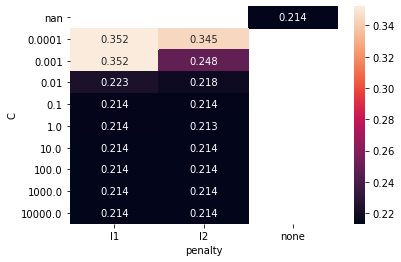

In [115]:
results9 = pd.DataFrame( best_model9.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results9['score_acc'] = 1 - best_model9.cv_results_['mean_test_accuracy']

# get rid of classifierXX in columns
cols9 = results9.columns.to_series().str.split('__').apply(lambda x: x[-1])
results9.columns = cols9

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results9.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results9

In [242]:
#assigning result
acc_9 = ("c = 1.0, penalty = l2, solver = saga, acc = 0.2132")

,classifier,C,penalty,solver,score_precision
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.352200
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.347233
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.352200
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.265420
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.217079
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.211438
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.202714
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.202332
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.201648
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.200770


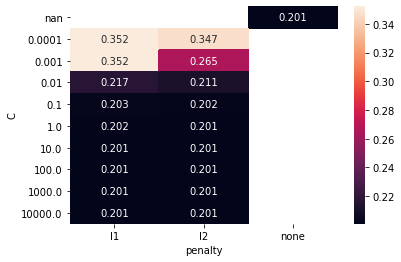

In [117]:
results9 = pd.DataFrame( best_model9.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results9['score_precision'] = 1 - best_model9.cv_results_['mean_test_precision']

# get rid of classifierXX in columns
cols9 = results9.columns.to_series().str.split('__').apply(lambda x: x[-1])
results9.columns = cols9

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results9.query('solver=="saga"').pivot('C','penalty','score_precision'),
             annot=True, fmt='.3f')

results9

In [243]:
#assigning result
precision_9 = ("C = 1.0, penality = l2, solver = saga, precision = 0.200770")

,classifier,C,penalty,solver,score_f1_micro
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3522
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3446
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3522
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2484
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2234
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2176
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.2142
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.2140
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.2140
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.2132


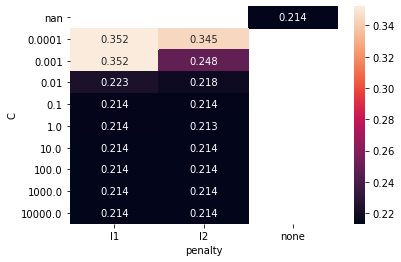

In [119]:
results9 = pd.DataFrame( best_model9.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results9['score_f1_micro'] = 1 - best_model9.cv_results_['mean_test_f1_micro']

# get rid of classifierXX in columns
cols9 = results9.columns.to_series().str.split('__').apply(lambda x: x[-1])
results9.columns = cols9

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results9.query('solver=="saga"').pivot('C','penalty','score_f1_micro'),
             annot=True, fmt='.3f')

results9

In [244]:
#assigning result
f1micro_9 = ("c = 1.0, penalty = l2, solver = saga, f1_micro = 0.2132")

#### Trial 10

In [121]:
#Defining X and Y
X_magic = magic_df.iloc[:,0:10]
Y_magic = magic_df.loc[:, "class"]
X_train, X_test, Y_train, Y_test = train_test_split( X_magic, Y_magic, train_size=5000, shuffle=True, random_state = 10)

In [122]:
%%time
# Create a pipeline - RF is a stand in, we will populate the classifier part below
pipe = Pipeline([('std', StandardScaler()),
                 ('classifier', LogisticRegression())])

# Create search space of candidate learning algorithms and their hyperparameters
# note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}
                ]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5),
                   scoring=['accuracy', 'precision','f1_micro'], refit=False,
                   verbose=0)

# Fit grid search
best_model10 = clf.fit(X_train, Y_train)

Wall time: 5.04 s


In [123]:
best_model10.cv_results_

{'mean_fit_time': array([0.00518398, 0.01297207, 0.00877581, 0.01217318, 0.01437106,
        0.01416178, 0.01944904, 0.03730049, 0.03720179, 0.0348084 ,
        0.05645242, 0.0516613 , 0.05106606, 0.0455792 , 0.06063762,
        0.05523686, 0.04547682, 0.03590336, 0.03675456, 0.00979733,
        0.01308904, 0.02968912, 0.01499729, 0.01520452, 0.01569242,
        0.02147388, 0.01595745, 0.03251271, 0.0522603 ]),
 'std_fit_time': array([0.00039076, 0.00062646, 0.00075447, 0.00075374, 0.0015037 ,
        0.00146534, 0.00533327, 0.00978414, 0.01061955, 0.00219492,
        0.0122048 , 0.01182417, 0.00694519, 0.00908268, 0.00341999,
        0.01439327, 0.00249345, 0.00315421, 0.03604263, 0.00223005,
        0.00215268, 0.01607544, 0.00089888, 0.0011767 , 0.00141395,
        0.00568604, 0.00109223, 0.01974213, 0.00663352]),
 'mean_score_time': array([0.00339313, 0.00338464, 0.00358987, 0.00318694, 0.00298581,
        0.00319166, 0.00598392, 0.00488811, 0.00339079, 0.00378962,
        0.004587

In [124]:
best_model10.cv_results_['rank_test_accuracy']

array([28, 26, 28, 24, 23, 21, 18, 19, 17, 15,  1,  1,  1,  5,  5,  5,  5,
        5, 26, 24, 21, 19, 15,  1,  5,  5,  5,  5,  5])

In [125]:
best_model10.cv_results_['params'][ np.argmin(best_model10.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 10.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [126]:
best_model10.cv_results_['params'][ np.argmin(best_model10.cv_results_['rank_test_precision'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 10.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [127]:
best_model10.cv_results_['params'][ np.argmin(best_model10.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 10.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3494
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3430
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3494
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2428
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2182
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2140
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.2104
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.2116
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.2094
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.2088


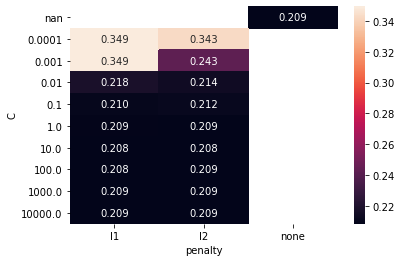

In [128]:
results10 = pd.DataFrame( best_model10.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results10['score_acc'] = 1 - best_model10.cv_results_['mean_test_accuracy']

# get rid of classifierXX in columns
cols10 = results10.columns.to_series().str.split('__').apply(lambda x: x[-1])
results10.columns = cols10

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results10.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results10

In [245]:
#assigning result
acc_10 = ("c = 10, penalty = l1, solver = saga, acc = 0.2084")

,classifier,C,penalty,solver,score_precision
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.349400
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.345202
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.349400
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.259266
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.213999
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.209166
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.199185
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.200192
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.197453
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.197291


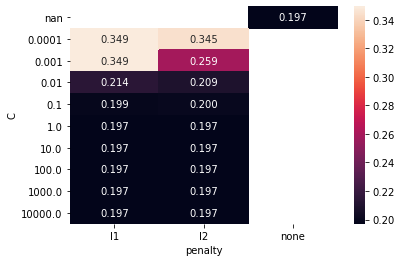

In [130]:
results10 = pd.DataFrame( best_model10.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results10['score_precision'] = 1 - best_model10.cv_results_['mean_test_precision']

# get rid of classifierXX in columns
cols10 = results10.columns.to_series().str.split('__').apply(lambda x: x[-1])
results10.columns = cols10

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results10.query('solver=="saga"').pivot('C','penalty','score_precision'),
             annot=True, fmt='.3f')

results10

In [246]:
#assigning result
precision_10 = ("c = 10, penalty = l1, solver = saga, precision = 0.197024")

,classifier,C,penalty,solver,score_f1_micro
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3494
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3430
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3494
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2428
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2182
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2140
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.2104
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.2116
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.2094
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.2088


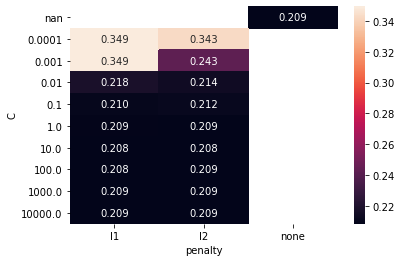

In [132]:
results10 = pd.DataFrame( best_model10.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results10['score_f1_micro'] = 1 - best_model10.cv_results_['mean_test_f1_micro']

# get rid of classifierXX in columns
cols10 = results10.columns.to_series().str.split('__').apply(lambda x: x[-1])
results10.columns = cols10

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results10.query('solver=="saga"').pivot('C','penalty','score_f1_micro'),
             annot=True, fmt='.3f')

results10

In [247]:
#assigning result
f1micro_10 = ("c = 10, penalty = l1, solver = saga, f1_micro = 0.2084")

#### Trial 11

In [134]:
#Defining X and Y
X_magic = magic_df.iloc[:,0:10]
Y_magic = magic_df.loc[:, "class"]
X_train, X_test, Y_train, Y_test = train_test_split( X_magic, Y_magic, train_size=5000, shuffle=True, random_state = 11)

In [135]:
%%time
# Create a pipeline - RF is a stand in, we will populate the classifier part below
pipe = Pipeline([('std', StandardScaler()),
                 ('classifier', LogisticRegression())])

# Create search space of candidate learning algorithms and their hyperparameters
# note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}
                ]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5),
                   scoring=['accuracy', 'precision','f1_micro'], refit=False,
                   verbose=0)

# Fit grid search
best_model11 = clf.fit(X_train, Y_train)

Wall time: 4.53 s


In [136]:
best_model11.cv_results_

{'mean_fit_time': array([0.0072288 , 0.01546454, 0.01216712, 0.02189755, 0.02154222,
        0.01416168, 0.04248629, 0.03051839, 0.04109011, 0.02991829,
        0.03331094, 0.03071804, 0.03902311, 0.03291154, 0.04538035,
        0.03091745, 0.03610325, 0.02932153, 0.01037226, 0.01097093,
        0.01236706, 0.02972035, 0.01715446, 0.02054505, 0.0335103 ,
        0.01934848, 0.02972074, 0.02034564, 0.03191442]),
 'std_fit_time': array([0.00038633, 0.00044644, 0.00074651, 0.01185333, 0.00506978,
        0.00097692, 0.01854694, 0.01182752, 0.0169188 , 0.00514201,
        0.01080825, 0.00659759, 0.00796274, 0.00785326, 0.0110729 ,
        0.00834432, 0.01054335, 0.00629498, 0.00279255, 0.00166904,
        0.00162043, 0.02513905, 0.00159559, 0.00726345, 0.02310356,
        0.0040192 , 0.00967719, 0.00241009, 0.00740983]),
 'mean_score_time': array([0.00398927, 0.00379   , 0.00927672, 0.00398912, 0.0031918 ,
        0.00379028, 0.00359068, 0.00398955, 0.00448971, 0.00401492,
        0.003789

In [137]:
best_model11.cv_results_['rank_test_accuracy']

array([28, 26, 28, 24, 23, 21, 18, 19,  1,  1, 11, 11, 11, 11, 11,  1, 11,
        1, 26, 24, 21, 19,  1,  1,  1,  1,  1,  1, 11])

In [138]:
best_model11.cv_results_['params'][ np.argmin(best_model11.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [139]:
best_model11.cv_results_['params'][ np.argmin(best_model11.cv_results_['rank_test_precision'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1000.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

In [140]:
best_model11.cv_results_['params'][ np.argmin(best_model11.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3438
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3374
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3438
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2484
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2200
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2118
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.2086
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.2088
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.2078
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.2078


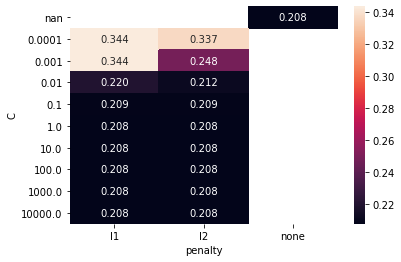

In [141]:
results11 = pd.DataFrame( best_model11.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results11['score_acc'] = 1 - best_model11.cv_results_['mean_test_accuracy']

# get rid of classifierXX in columns
cols11 = results11.columns.to_series().str.split('__').apply(lambda x: x[-1])
results11.columns = cols11

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results11.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results11

In [248]:
#assigning result
acc_11 = ("c = 0.1, penalty = l1, solver = saga, acc = 0.1554")

,classifier,C,penalty,solver,score_precision
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.343800
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.339506
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.343800
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.264628
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.213435
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.204597
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.195810
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.195553
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.194127
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.193971


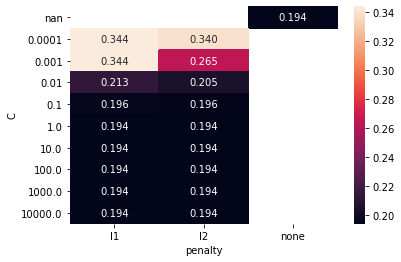

In [143]:
results11 = pd.DataFrame( best_model11.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results11['score_precision'] = 1 - best_model11.cv_results_['mean_test_precision']

# get rid of classifierXX in columns
cols11 = results11.columns.to_series().str.split('__').apply(lambda x: x[-1])
results11.columns = cols11

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results11.query('solver=="saga"').pivot('C','penalty','score_precision'),
             annot=True, fmt='.3f')

results11

In [249]:
#assigning result
precision_11 = ("C = 1000, penality = l2, solver = saga, precision = 0.193796")

,classifier,C,penalty,solver,score_f1_micro
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3438
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3374
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3438
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2484
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2200
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2118
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.2086
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.2088
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.2078
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.2078


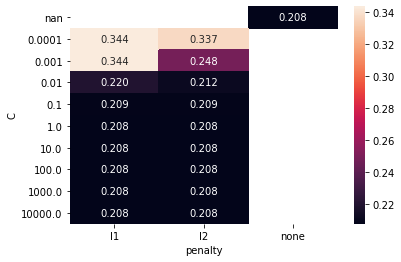

In [145]:
results11 = pd.DataFrame( best_model11.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results11['score_f1_micro'] = 1 - best_model11.cv_results_['mean_test_f1_micro']

# get rid of classifierXX in columns
cols11 = results11.columns.to_series().str.split('__').apply(lambda x: x[-1])
results11.columns = cols11

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results11.query('solver=="saga"').pivot('C','penalty','score_f1_micro'),
             annot=True, fmt='.3f')

results11

In [250]:
#assigning result
f1micro_11 = ("c = 1.0, penalty = l1, solver = saga, f1_micro = 0.2078")

#### Trial 12

In [147]:
#Defining X and Y
X_magic = magic_df.iloc[:,0:10]
Y_magic = magic_df.loc[:, "class"]
X_train, X_test, Y_train, Y_test = train_test_split( X_magic, Y_magic, train_size=5000, shuffle=True, random_state = 12)

In [148]:
%%time
# Create a pipeline - RF is a stand in, we will populate the classifier part below
pipe = Pipeline([('std', StandardScaler()),
                 ('classifier', LogisticRegression())])

# Create search space of candidate learning algorithms and their hyperparameters
# note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}
                ]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5),
                   scoring=['accuracy', 'precision','f1_micro'], refit=False,
                   verbose=0)

# Fit grid search
best_model12 = clf.fit(X_train, Y_train)

Wall time: 5.21 s


In [149]:
best_model12.cv_results_

{'mean_fit_time': array([0.00678172, 0.0169548 , 0.00997372, 0.01256638, 0.01625786,
        0.01337996, 0.02683454, 0.02573137, 0.05011158, 0.03376622,
        0.04398479, 0.03849688, 0.04747295, 0.03789835, 0.04547858,
        0.04248652, 0.0466753 , 0.03309884, 0.00997291, 0.00957432,
        0.01695452, 0.01675501, 0.01696095, 0.02867765, 0.01678691,
        0.01629071, 0.07336521, 0.10600643, 0.04460926]),
 'std_fit_time': array([0.00097712, 0.00154496, 0.00154493, 0.00048827, 0.00132539,
        0.00049331, 0.01059046, 0.00593006, 0.00874988, 0.00414547,
        0.00626512, 0.01598984, 0.01129405, 0.0052013 , 0.01029963,
        0.01187779, 0.00770963, 0.00805729, 0.00109254, 0.00135283,
        0.00339647, 0.00247494, 0.00315924, 0.02269405, 0.00097714,
        0.0009857 , 0.10340883, 0.09422315, 0.01067195]),
 'mean_score_time': array([0.00418873, 0.0045877 , 0.00378947, 0.00359039, 0.00339084,
        0.0034977 , 0.00398951, 0.00438819, 0.00468907, 0.00389247,
        0.003589

In [150]:
best_model12.cv_results_['rank_test_accuracy']

array([28, 26, 28, 24, 23, 21,  1,  2,  6,  4,  6,  8,  8,  8,  8,  8,  8,
        8, 26, 24, 21,  2,  4,  8,  8,  8,  8,  8,  8])

In [151]:
best_model12.cv_results_['params'][ np.argmin(best_model12.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [152]:
best_model12.cv_results_['params'][ np.argmin(best_model12.cv_results_['rank_test_precision'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

In [153]:
best_model12.cv_results_['params'][ np.argmin(best_model12.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3460
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3370
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3460
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2450
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2192
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2154
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.2092
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.2104
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.2108
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.2106


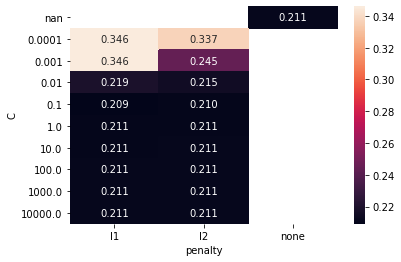

In [154]:
results12 = pd.DataFrame( best_model12.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results12['score_acc'] = 1 - best_model12.cv_results_['mean_test_accuracy']

# get rid of classifierXX in columns
cols12 = results12.columns.to_series().str.split('__').apply(lambda x: x[-1])
results12.columns = cols12

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results12.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results12

In [251]:
#assigning result
acc_12 = ("c = 0.1, penalty = l1, solver = saga, acc = 0.2092")

,classifier,C,penalty,solver,score_precision
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.346000
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.340057
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.346000
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.263158
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.214976
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.210843
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.200226
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.200537
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.199846
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.199627


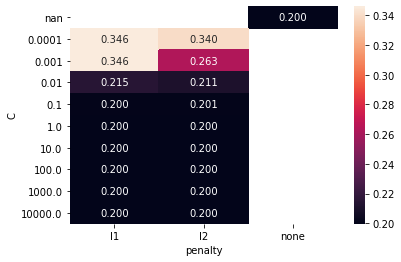

In [156]:
results12 = pd.DataFrame( best_model12.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results12['score_precision'] = 1 - best_model12.cv_results_['mean_test_precision']

# get rid of classifierXX in columns
cols12 = results12.columns.to_series().str.split('__').apply(lambda x: x[-1])
results12.columns = cols12

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results12.query('solver=="saga"').pivot('C','penalty','score_precision'),
             annot=True, fmt='.3f')

results12

In [252]:
#assigning result
precision_12 = ("C = 1.0, penality = l2, solver = saga, precision = 0.199627")

,classifier,C,penalty,solver,score_f1_micro
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3460
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3370
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3460
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2450
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2192
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2154
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.2092
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.2104
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.2108
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.2106


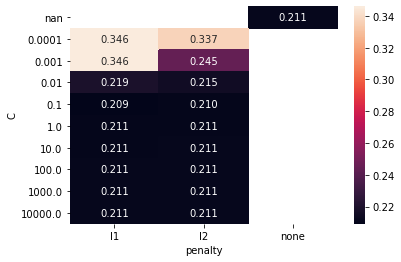

In [158]:
results12 = pd.DataFrame( best_model12.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results12['score_f1_micro'] = 1 - best_model12.cv_results_['mean_test_f1_micro']

# get rid of classifierXX in columns
cols12 = results12.columns.to_series().str.split('__').apply(lambda x: x[-1])
results12.columns = cols12

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results12.query('solver=="saga"').pivot('C','penalty','score_f1_micro'),
             annot=True, fmt='.3f')

results12

In [253]:
#assigning result
f1micro_12 = ("c = 0.1, penalty = l1, solver = saga, f1_micro = 0.2092")

#### Trial 13

In [160]:
#Defining X and Y
X_magic = magic_df.iloc[:,0:10]
Y_magic = magic_df.loc[:, "class"]
X_train, X_test, Y_train, Y_test = train_test_split( X_magic, Y_magic, train_size=5000, shuffle=True, random_state = 13)

In [161]:
%%time
# Create a pipeline - RF is a stand in, we will populate the classifier part below
pipe = Pipeline([('std', StandardScaler()),
                 ('classifier', LogisticRegression())])

# Create search space of candidate learning algorithms and their hyperparameters
# note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}
                ]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5),
                   scoring=['accuracy', 'precision','f1_micro'], refit=False,
                   verbose=0)

# Fit grid search
best_model13 = clf.fit(X_train, Y_train)

Wall time: 4.21 s


In [162]:
best_model13.cv_results_

{'mean_fit_time': array([0.01805329, 0.01865153, 0.00957417, 0.01336417, 0.0203454 ,
        0.01296539, 0.02752609, 0.01994629, 0.03311081, 0.02902403,
        0.03111668, 0.0296    , 0.03575368, 0.03111644, 0.03819914,
        0.028826  , 0.03829741, 0.02932153, 0.01276574, 0.0183507 ,
        0.02672834, 0.03271232, 0.02972064, 0.02712765, 0.0155581 ,
        0.01396294, 0.01376314, 0.0139627 , 0.02573133]),
 'std_fit_time': array([0.02414656, 0.00243517, 0.00101698, 0.00162071, 0.00704099,
        0.00089218, 0.00873135, 0.00274954, 0.00540376, 0.00357274,
        0.00632019, 0.00274192, 0.00870479, 0.00452227, 0.00717545,
        0.00726088, 0.00466079, 0.00544809, 0.00330217, 0.00816589,
        0.02660748, 0.01168892, 0.00671692, 0.00572586, 0.00623167,
        0.00166878, 0.00171603, 0.00141017, 0.00369943]),
 'mean_score_time': array([0.00339079, 0.00558515, 0.00418911, 0.00359039, 0.00458808,
        0.00378995, 0.0031918 , 0.00359077, 0.00379009, 0.00398936,
        0.005087

In [163]:
best_model13.cv_results_['rank_test_accuracy']

array([28, 26, 28, 24, 23, 21,  1, 19,  2,  2,  5,  5,  5,  5,  5,  5,  5,
        5, 26, 24, 21, 19,  2,  5,  5,  5,  5,  5,  5])

In [164]:
best_model13.cv_results_['params'][ np.argmin(best_model13.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [165]:
best_model13.cv_results_['params'][ np.argmin(best_model13.cv_results_['rank_test_precision'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 10.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [166]:
best_model13.cv_results_['params'][ np.argmin(best_model13.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3522
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3434
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3522
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2456
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2152
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2138
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.2082
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.2106
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.2086
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.2086


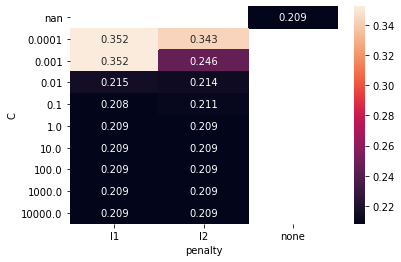

In [167]:
results13 = pd.DataFrame( best_model13.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results13['score_acc'] = 1 - best_model13.cv_results_['mean_test_accuracy']

# get rid of classifierXX in columns
cols13 = results13.columns.to_series().str.split('__').apply(lambda x: x[-1])
results13.columns = cols13

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results13.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results13

In [254]:
#assigning result
acc_13 = ("c = 0.1, penalty = l1, solver = saga, acc = 0.2082")

,classifier,C,penalty,solver,score_precision
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.352200
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.346446
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.352200
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.263905
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.212449
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.208440
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.198030
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.199668
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.197140
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.197140


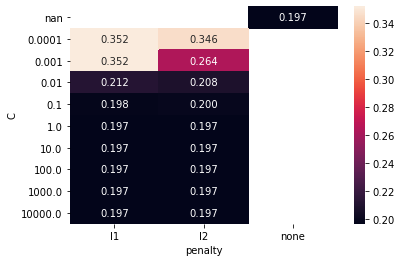

In [169]:
results13 = pd.DataFrame( best_model13.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results13['score_precision'] = 1 - best_model13.cv_results_['mean_test_precision']

# get rid of classifierXX in columns
cols13 = results13.columns.to_series().str.split('__').apply(lambda x: x[-1])
results13.columns = cols13

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results13.query('solver=="saga"').pivot('C','penalty','score_precision'),
             annot=True, fmt='.3f')

results13

In [255]:
#assigning result
precision_13 = ("C = 10.0, penality = l1, solver = saga, precision = 0.196803")

,classifier,C,penalty,solver,score_f1_micro
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3522
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3434
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3522
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2456
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2152
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2138
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.2082
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.2106
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.2086
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.2086


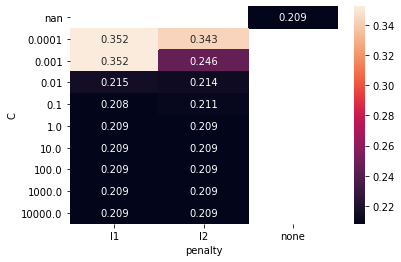

In [171]:
results13 = pd.DataFrame( best_model13.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results13['score_f1_micro'] = 1 - best_model13.cv_results_['mean_test_f1_micro']

# get rid of classifierXX in columns
cols13 = results13.columns.to_series().str.split('__').apply(lambda x: x[-1])
results13.columns = cols13

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results13.query('solver=="saga"').pivot('C','penalty','score_f1_micro'),
             annot=True, fmt='.3f')

results13

In [256]:
#assigning result
f1micro_13 = ("c = 0.1, penalty = l1, solver = saga, f1_micro = 0.2082")

#### Trial 14

In [173]:
#Defining X and Y
X_magic = magic_df.iloc[:,0:10]
Y_magic = magic_df.loc[:, "class"]
X_train, X_test, Y_train, Y_test = train_test_split( X_magic, Y_magic, train_size=5000, shuffle=True, random_state = 14)

In [174]:
%%time
# Create a pipeline - RF is a stand in, we will populate the classifier part below
pipe = Pipeline([('std', StandardScaler()),
                 ('classifier', LogisticRegression())])

# Create search space of candidate learning algorithms and their hyperparameters
# note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}
                ]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5),
                   scoring=['accuracy', 'precision','f1_micro'], refit=False,
                   verbose=0)

# Fit grid search
best_model14 = clf.fit(X_train, Y_train)

Wall time: 4.54 s


In [175]:
best_model14.cv_results_

{'mean_fit_time': array([0.00618329, 0.01276569, 0.00817819, 0.01276579, 0.01356411,
        0.01196799, 0.02054515, 0.026928  , 0.0432838 , 0.03909564,
        0.05362349, 0.04216914, 0.05117908, 0.04072857, 0.05458961,
        0.04604564, 0.05624957, 0.04227219, 0.00877199, 0.00877671,
        0.01266732, 0.02054505, 0.02892265, 0.01436172, 0.01635628,
        0.01496015, 0.01296496, 0.01496024, 0.04174294]),
 'std_fit_time': array([0.00146551, 0.00097729, 0.00039878, 0.00039895, 0.0004893 ,
        0.00089212, 0.00626357, 0.00218492, 0.00998522, 0.00385777,
        0.00366987, 0.00482462, 0.00604642, 0.00339678, 0.00717318,
        0.00632406, 0.00381631, 0.0035012 , 0.00116639, 0.00097729,
        0.00171566, 0.00411668, 0.02304703, 0.00249162, 0.00205355,
        0.00141067, 0.0016689 , 0.00252312, 0.00353944]),
 'mean_score_time': array([0.00369315, 0.00339127, 0.00329456, 0.00299234, 0.00339098,
        0.00339074, 0.00378971, 0.00398932, 0.00319161, 0.00339088,
        0.003691

In [176]:
best_model14.cv_results_['rank_test_accuracy']

array([28, 26, 28, 24, 23, 21, 18, 19, 17, 12, 14, 14,  1,  1,  1,  1,  1,
        1, 26, 24, 21, 19, 12, 14,  1,  1,  1,  1,  1])

In [177]:
best_model14.cv_results_['params'][ np.argmin(best_model14.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 100.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [178]:
best_model14.cv_results_['params'][ np.argmin(best_model14.cv_results_['rank_test_precision'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 100.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [179]:
best_model14.cv_results_['params'][ np.argmin(best_model14.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 100.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3532
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3440
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3532
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2492
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2186
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2134
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.2082
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.2084
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.2074
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.2072


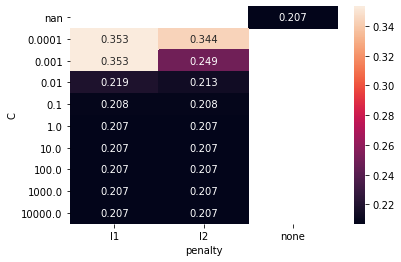

In [180]:
results14 = pd.DataFrame( best_model14.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results14['score_acc'] = 1 - best_model14.cv_results_['mean_test_accuracy']

# get rid of classifierXX in columns
cols14 = results14.columns.to_series().str.split('__').apply(lambda x: x[-1])
results14.columns = cols14

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results14.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results14

In [257]:
#assigning result
acc_14 = ("c = 100.0, penalty = l1, solver = saga, acc = 0.2070")

,classifier,C,penalty,solver,score_precision
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.353200
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.347180
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.353200
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.263737
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.216163
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.210626
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.200181
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.199589
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.197979
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.197765


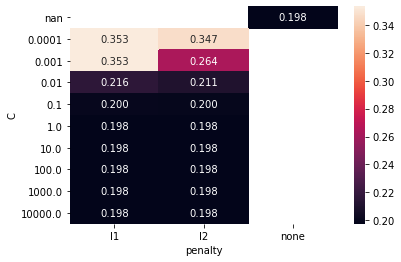

In [182]:
results14 = pd.DataFrame( best_model14.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results14['score_precision'] = 1 - best_model14.cv_results_['mean_test_precision']

# get rid of classifierXX in columns
cols14 = results14.columns.to_series().str.split('__').apply(lambda x: x[-1])
results14.columns = cols14

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results14.query('solver=="saga"').pivot('C','penalty','score_precision'),
             annot=True, fmt='.3f')

results14

In [258]:
#assigning result
precision_14 = ("c = 100.0, penalty = l1, solver = saga, precision = 0.197545")

,classifier,C,penalty,solver,score_f1_micro
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3532
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3440
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3532
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2492
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2186
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2134
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.2082
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.2084
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.2074
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.2072


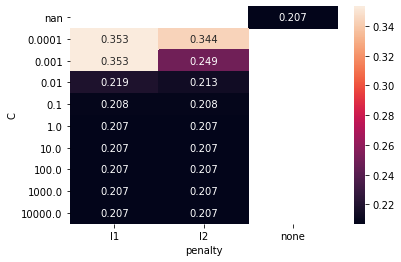

In [184]:
results14 = pd.DataFrame( best_model14.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results14['score_f1_micro'] = 1 - best_model14.cv_results_['mean_test_f1_micro']

# get rid of classifierXX in columns
cols14 = results14.columns.to_series().str.split('__').apply(lambda x: x[-1])
results14.columns = cols14

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results14.query('solver=="saga"').pivot('C','penalty','score_f1_micro'),
             annot=True, fmt='.3f')

results14

In [259]:
#assigning result
f1micro_14 = ("c = 100.0, penalty = l1, solver = saga, f1_micro = 0.2070")

#### Trial 15

In [186]:
#Defining X and Y
X_magic = magic_df.iloc[:,0:10]
Y_magic = magic_df.loc[:, "class"]
X_train, X_test, Y_train, Y_test = train_test_split( X_magic, Y_magic, train_size=5000, shuffle=True, random_state = 15)

In [187]:
%%time
# Create a pipeline - RF is a stand in, we will populate the classifier part below
pipe = Pipeline([('std', StandardScaler()),
                 ('classifier', LogisticRegression())])

# Create search space of candidate learning algorithms and their hyperparameters
# note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}
                ]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5),
                   scoring=['accuracy', 'precision','f1_micro'], refit=False,
                   verbose=0)

# Fit grid search
best_model15 = clf.fit(X_train, Y_train)

Wall time: 4.46 s


In [188]:
best_model15.cv_results_

{'mean_fit_time': array([0.00520725, 0.01738997, 0.01468673, 0.01168737, 0.01480155,
        0.01229267, 0.01537571, 0.02657413, 0.0493536 , 0.03853893,
        0.0454843 , 0.03888917, 0.05196233, 0.03989787, 0.0586431 ,
        0.03769894, 0.05167642, 0.03850284, 0.0101727 , 0.01167016,
        0.01017261, 0.01256628, 0.01396232, 0.01416206, 0.02393603,
        0.01495991, 0.01476045, 0.01737142, 0.04635148]),
 'std_fit_time': array([0.00074567, 0.0027767 , 0.01040456, 0.0003959 , 0.00104192,
        0.00075624, 0.00135069, 0.00288968, 0.00611188, 0.00717313,
        0.00483048, 0.0030776 , 0.00966336, 0.00546467, 0.01697701,
        0.00353432, 0.00523654, 0.00507779, 0.00212996, 0.00665702,
        0.00074654, 0.00079802, 0.00089223, 0.00159591, 0.00975155,
        0.00289066, 0.00132302, 0.00372183, 0.00632853]),
 'mean_score_time': array([0.00338917, 0.00529451, 0.00429273, 0.0035996 , 0.00309486,
        0.00339766, 0.00352354, 0.00329981, 0.00359616, 0.00369596,
        0.003390

In [189]:
best_model15.cv_results_['rank_test_accuracy']

array([28, 26, 28, 24, 23, 21, 18, 20, 15, 15, 12, 13,  1,  1,  1,  1,  1,
        1, 26, 25, 21, 19, 17, 13,  1,  1,  1,  1,  1])

In [190]:
best_model15.cv_results_['params'][ np.argmin(best_model15.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 100.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [191]:
best_model15.cv_results_['params'][ np.argmin(best_model15.cv_results_['rank_test_precision'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 100.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [192]:
best_model15.cv_results_['params'][ np.argmin(best_model15.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 100.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3496
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3394
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3496
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2416
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2166
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2140
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.2084
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.2106
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.2078
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.2078


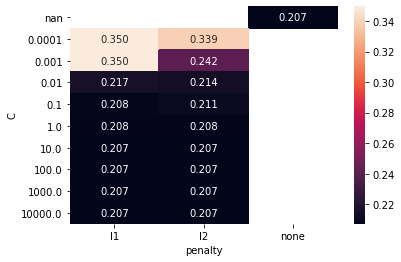

In [193]:
results15 = pd.DataFrame( best_model15.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results15['score_acc'] = 1 - best_model15.cv_results_['mean_test_accuracy']

# get rid of classifierXX in columns
cols15 = results15.columns.to_series().str.split('__').apply(lambda x: x[-1])
results15.columns = cols15

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results15.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results15

In [260]:
#assigning result
acc_15 = ("c = 100.0, penalty = l1, solver = saga, acc = 0.2072")

,classifier,C,penalty,solver,score_precision
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.349600
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.342827
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.349600
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.260149
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.211229
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.208432
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.198023
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.199312
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.195739
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.196061


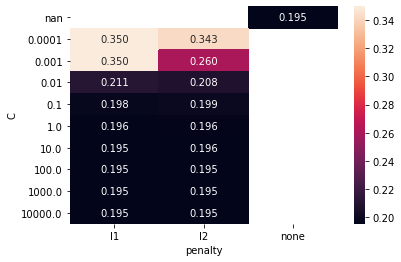

In [195]:
results15 = pd.DataFrame( best_model15.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results15['score_precision'] = 1 - best_model15.cv_results_['mean_test_precision']

# get rid of classifierXX in columns
cols15 = results15.columns.to_series().str.split('__').apply(lambda x: x[-1])
results15.columns = cols15

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results15.query('solver=="saga"').pivot('C','penalty','score_precision'),
             annot=True, fmt='.3f')

results15

In [261]:
#assigning result
precision_15 = ("c = 100.0, penalty = l1, solver = saga, precision = 0.195397")

,classifier,C,penalty,solver,score_f1_micro
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3496
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3394
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3496
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2416
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2166
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2140
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.2084
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.2106
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.2078
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.2078


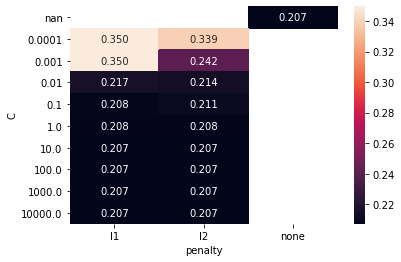

In [197]:
results15 = pd.DataFrame( best_model15.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results15['score_f1_micro'] = 1 - best_model15.cv_results_['mean_test_f1_micro']

# get rid of classifierXX in columns
cols15 = results15.columns.to_series().str.split('__').apply(lambda x: x[-1])
results15.columns = cols15

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results15.query('solver=="saga"').pivot('C','penalty','score_f1_micro'),
             annot=True, fmt='.3f')

results15

In [262]:
#assigning result
f1micro_15 = ("c = 100.0, penalty = l1, solver = saga, f1_micro = 0.2072")

## Training Results

In [266]:
#adding results into a list
acc_List = [acc_1,acc_2,acc_3,acc_4,acc_5,acc_6,acc_7,acc_8,acc_9,acc_10,acc_11,acc_12,acc_13,acc_14,acc_15]
precision_List = [precision_1,precision_2,precision_3,precision_4,precision_5,precision_6,precision_7,precision_8,precision_9,precision_10,precision_11,precision_12,precision_13,precision_14,precision_15]
f1micro_List = [f1micro_1,f1micro_2,f1micro_3,f1micro_4,f1micro_5,f1micro_6,f1micro_7,f1micro_8,f1micro_9,f1micro_10,f1micro_11,f1micro_12,f1micro_13,f1micro_14,f1micro_15]

In [267]:
#creating dataframe of results
data = {'Acc': acc_List, 'Precision': precision_List, 'F1_micro':f1micro_List}

In [268]:
trainingResults  = pd.DataFrame(data = data)
pd.options.display.max_colwidth = 100
trainingResults

,Acc,Precision,F1_micro
0,"c = 1.0, penalty = l1, solver = saga, acc = 0.2012","C = 10, penality = l1, solver = saga, precision = 0.188416","c = 1.0, penalty = l1, solver = saga, f1_micro = 0.2012"
1,"c = 10.0, penalty = l1, solver = saga, acc = 0.2108","c = 10.0, penalty = l1, solver = saga, precision = 0.198584","c = 10.0, penalty = l1, solver = saga, f1_micro = 0.2108"
2,"c = 1.0, penalty = l2, solver = saga, acc = 0.2090","C = 1.0, penality = l2, solver = saga, precision = 0.199272","c = 1.0, penalty = l2, solver = saga, f1_micro = 0.2090"
3,"c = 0.01, penalty = l2, solver = lbfgs, acc = 0.2158","c = 1.0, penalty = l2, solver = saga, precision = 0.204111","c = 0.01, penalty = l2, solver = lbfgs, f1_micro = 0.2158"
4,"c = 0.1, penalty = l1, solver = saga, acc = 0.2076","C = 10.0, penality = l2, solver = saga, precision = 0.196507","c = 0.1, penalty = l1, solver = saga, f1_micro = 0.2076"
5,"c = 0.1, penalty = l1, solver = saga, acc = 0.2084","C = 1.0, penality = l1, solver = saga, precision = 0.195254","c = 0.1, penalty = l1, solver = saga, f1_micro = 0.2084"
6,"c = 0.1, penalty = l2, solver = saga, acc = 0.2148","C = 1.0, penality = l2, solver = saga, precision = 0.202359","c = 0.1, penalty = l2, solver = saga, f1_micro = 0.2148"
7,"c = 0.1, penalty = l1, solver = saga, acc = 0.2132","c = 10.0, penalty = l1, solver = saga, precision = 0.201583","c = 0.1, penalty = l1, solver = saga, f1_micro = 0.2132"
8,"c = 1.0, penalty = l2, solver = saga, acc = 0.2132","C = 1.0, penality = l2, solver = saga, precision = 0.200770","c = 1.0, penalty = l2, solver = saga, f1_micro = 0.2132"
9,"c = 10, penalty = l1, solver = saga, acc = 0.2084","c = 10, penalty = l1, solver = saga, precision = 0.197024","c = 10, penalty = l1, solver = saga, f1_micro = 0.2084"


## Testing Dataset

In [202]:
#Defining X and Y
X_magic = magic_df.iloc[:,0:10]
Y_magic = magic_df.loc[:, "class"]
X_train, X_test, Y_train, Y_test = train_test_split( X_magic, Y_magic, train_size=5000, shuffle=True, random_state = 16)

In [203]:
%%time
# Create a pipeline - RF is a stand in, we will populate the classifier part below
pipe = Pipeline([('std', StandardScaler()),
                 ('classifier', LogisticRegression())])

# Create search space of candidate learning algorithms and their hyperparameters
# note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}
                ]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5),
                   scoring=['accuracy', 'precision','f1_micro'], refit=False,
                   verbose=0)

# Fit grid search
best_model16 = clf.fit(X_test, Y_test)

Wall time: 8.93 s


In [204]:
best_model16.cv_results_

{'mean_fit_time': array([0.01117063, 0.04049153, 0.04667511, 0.03610334, 0.07779207,
        0.05605011, 0.04815707, 0.05897841, 0.0622551 , 0.05607018,
        0.09204688, 0.0558588 , 0.05754051, 0.05046501, 0.09794064,
        0.07330894, 0.07928905, 0.07111197, 0.04099236, 0.04607992,
        0.05655122, 0.03281441, 0.04218869, 0.04607697, 0.03321314,
        0.02992053, 0.03381128, 0.02732501, 0.06263571]),
 'std_fit_time': array([0.00074603, 0.00214868, 0.00517856, 0.00182843, 0.03383859,
        0.0145132 , 0.00555582, 0.0110361 , 0.01560348, 0.00340463,
        0.01754355, 0.00451086, 0.00627934, 0.00223936, 0.02089459,
        0.01395423, 0.02281687, 0.00897727, 0.00748948, 0.02467761,
        0.01999953, 0.00723767, 0.00628851, 0.03254033, 0.00469605,
        0.00260109, 0.00487201, 0.00148946, 0.00553782]),
 'mean_score_time': array([0.0061831 , 0.00757976, 0.00757976, 0.00638299, 0.01635628,
        0.01296525, 0.0103931 , 0.00639968, 0.01150122, 0.00559316,
        0.018094

In [205]:
best_model16.cv_results_['rank_test_accuracy']

array([29, 27, 26, 24, 23, 21, 18, 19,  3,  1,  3,  3,  3,  3,  3,  3,  3,
        3, 27, 25, 21, 19,  1,  3,  3,  3,  3,  3,  3])

In [206]:
best_model16.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [207]:
best_model16.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_precision'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 10.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [208]:
best_model16.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.354779
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.305064
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.255635
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.227247
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.213623
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.212482
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.211412
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.211626
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.211270
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.211198


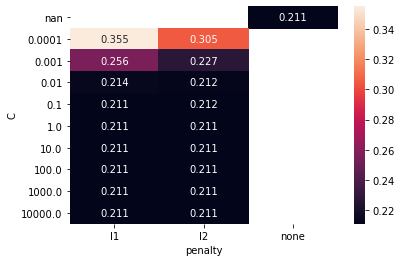

In [209]:
results16 = pd.DataFrame( best_model16.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results16['score_acc'] = 1 - best_model16.cv_results_['mean_test_accuracy']

# get rid of classifierXX in columns
cols16 = results16.columns.to_series().str.split('__').apply(lambda x: x[-1])
results16.columns = cols16

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results16.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results16

In [263]:
#assigning result
acc_16 = ("c = 1.0, penalty = l1, solver = saga, acc = 0.211270")

,classifier,C,penalty,solver,score_precision
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.354779
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.320642
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.260759
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.232382
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.205770
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.204650
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.200857
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.200922
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.200289
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.200212


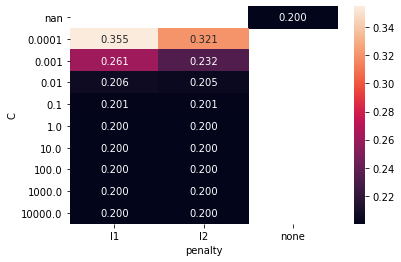

In [211]:
results16 = pd.DataFrame( best_model16.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results16['score_precision'] = 1 - best_model16.cv_results_['mean_test_precision']

# get rid of classifierXX in columns
cols16 = results16.columns.to_series().str.split('__').apply(lambda x: x[-1])
results16.columns = cols16

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results16.query('solver=="saga"').pivot('C','penalty','score_precision'),
             annot=True, fmt='.3f')

results16

In [264]:
#assigning result
precision_16 = ("C = 10, penality = l1, solver = saga, precision = 0.200231")

,classifier,C,penalty,solver,score_f1_micro
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.354779
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.305064
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.255635
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.227247
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.213623
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.212482
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.211412
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.211626
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.211270
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.211198


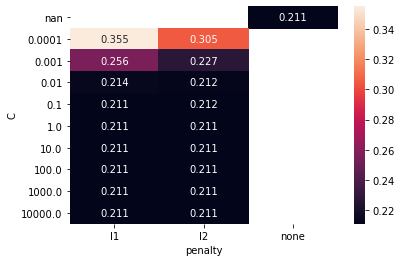

In [213]:
results16 = pd.DataFrame( best_model16.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results16['score_f1_micro'] = 1 - best_model16.cv_results_['mean_test_f1_micro']

# get rid of classifierXX in columns
cols16 = results16.columns.to_series().str.split('__').apply(lambda x: x[-1])
results16.columns = cols16

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results16.query('solver=="saga"').pivot('C','penalty','score_f1_micro'),
             annot=True, fmt='.3f')

results16

In [265]:
#assigning result
f1micro_16 = ("c = 1.0, penalty = l1, solver = saga, f1_micro = 0.211270")

## Testing Results

In [269]:
#defining results
test_acc = [acc_16]
test_precision = [precision_16]
test_f1micro = [f1micro_16]

In [270]:
#adding result to a dataframe
data = {'Acc': test_acc, 'Precision': test_precision, 'F1_micro': test_f1micro}

In [271]:
trainingResults  = pd.DataFrame(data = data)
pd.options.display.max_colwidth = 100
trainingResults

,Acc,Precision,F1_micro
0,"c = 1.0, penalty = l1, solver = saga, acc = 0.211270","C = 10, penality = l1, solver = saga, precision = 0.200231","c = 1.0, penalty = l1, solver = saga, f1_micro = 0.211270"
